In [26]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

# Download census-income dataset

In [34]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [36]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

File already exists.


# Load data and split

In [5]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [6]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

 State-gov 9
 Bachelors 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 United-States 42
 <=50K 2
Set 3


# Define categorical features for categorical embeddings

In [7]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# define your embedding sizes : here just a random choice
cat_emb_dim = [5, 4, 3, 6, 2, 2, 1, 10]

# Network parameters

In [18]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

Device used : cpu


# Training

In [19]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [20]:
clf.fit(
    X_train=X_train, y_train=y_train,
    X_valid=X_valid, y_valid=y_valid,
    max_epochs=1000,
    patience=50,
    batch_size=1024, virtual_batch_size=128
) 

Will train until validation stopping metric hasn't improved in 50 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
| 1     | -0.16201 |  -0.14080 |   3.3       
| 2     | -0.13356 |  -0.13456 |   6.6       
| 3     | -0.12741 |  -0.12347 |   10.0      
| 4     | -0.12197 |  -0.12200 |   13.3      
| 5     | -0.11826 |  -0.11754 |   16.6      
| 6     | -0.11633 |  -0.11343 |   19.9      
| 7     | -0.11474 |  -0.11092 |   23.4      
| 8     | -0.11505 |  -0.11150 |   27.3      
| 9     | -0.11430 |  -0.10962 |   31.2      
| 10    | -0.11337 |  -0.11150 |   35.3      
Training done in 35.326 seconds.
---------------------------------------


In [21]:
# Deprecated : best model is automatically loaded at end of fit
# clf.load_best_model()

preds = clf.predict(X_test)

y_true = y_test

test_auc = mean_squared_error(y_pred=preds, y_true=y_true)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR census-income : 0.10961568355560303
FINAL TEST SCORE FOR census-income : 0.11148223302016319


# Global explainability : feat importance summing to 1

In [22]:
clf.feature_importances_

array([5.22128232e-02, 4.39535934e-02, 8.80793065e-04, 2.23418903e-01,
       1.53268681e-05, 2.61220855e-01, 4.51454852e-02, 4.24610413e-02,
       6.75696158e-02, 5.10455698e-02, 1.45175457e-01, 5.45079558e-03,
       7.18206432e-03, 5.42676761e-02])

# Local explainability and masks

In [23]:
explain_matrix, masks = clf.explain(X_test)

In [24]:
from matplotlib import pyplot as plt
%matplotlib inline

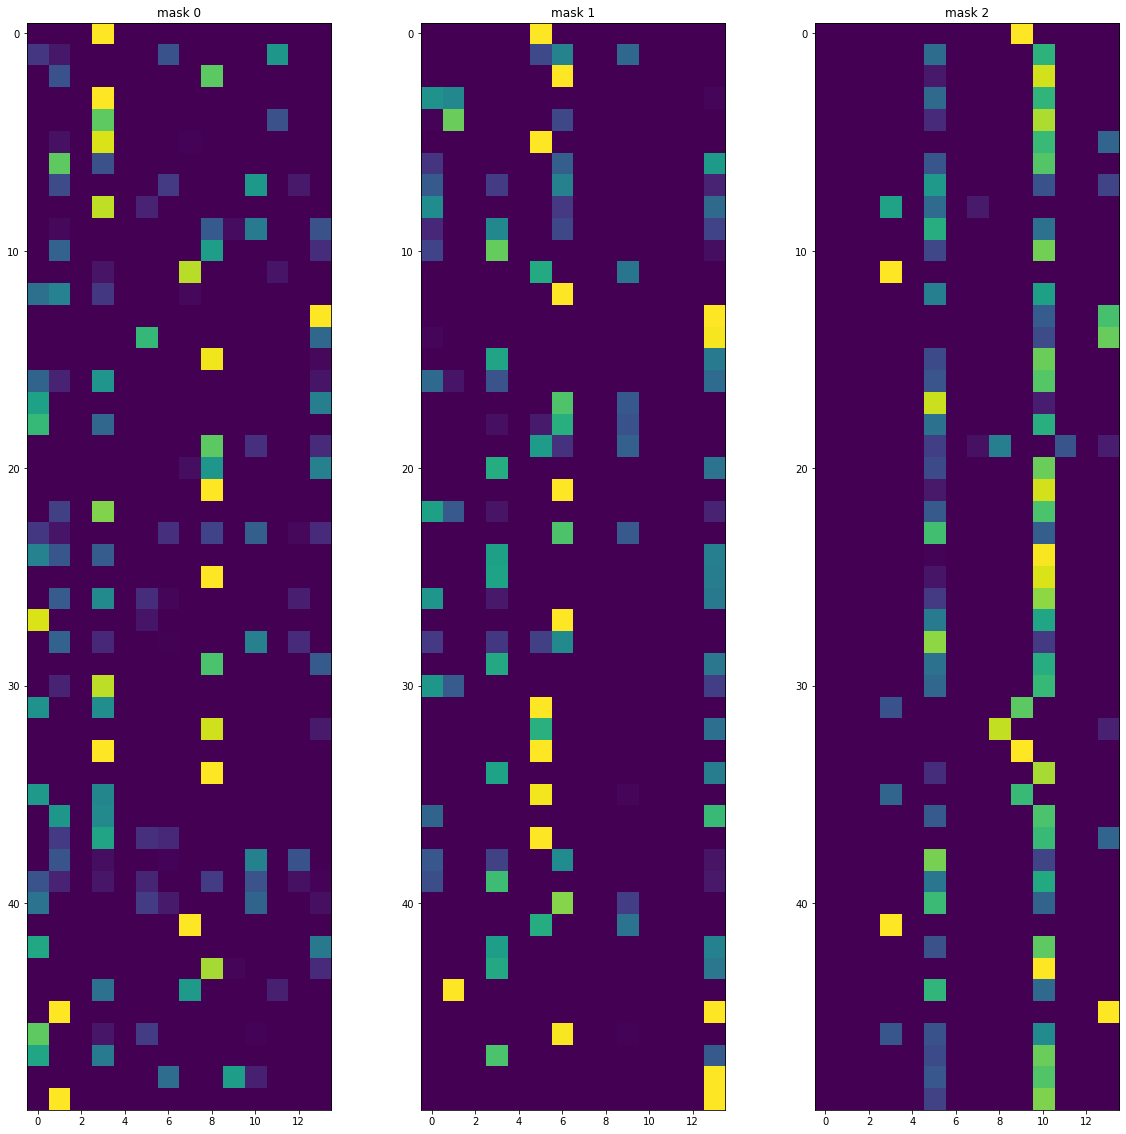

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


# XGB

In [ ]:
from xgboost import XGBRegressor

clf_xgb = XGBRegressor(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

In [ ]:
preds = np.array(clf_xgb.predict(X_valid))
valid_auc = mean_squared_error(y_pred=preds, y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict(X_test))
test_auc = mean_squared_error(y_pred=preds, y_true=y_test)
print(test_auc)